# LightGBM Interpretability with ShAP

LightGBM offers a scalable solution that accomodates tabular and categorical inputs out of the box. 

### Setup

In [4]:
# Extension reloader to import a function again when re-running cell 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load Configuration

In [2]:
"""
Loads common configuration parameters
"""
from project.src.utils.configuration_manager import Config
from pathlib import Path, PurePath
parent_dir = Path().resolve().parent

config_path = PurePath(parent_dir, 'config.ini')
config = Config(config_path)

Loading configuration from: /home/justin/Code/interpretability_project/project/config.ini
raw_input: /home/justin/Code/interpretability_project/project/data/raw
input_path: /home/justin/Code/interpretability_project/project/data/interim/2018_Yellow_Taxi_Trip_Data_float64
figures_dir: /home/justin/Code/interpretability_project/project/figures
preprocessed_dir: /home/justin/Code/interpretability_project/project/data/preprocessed
train_data: /home/justin/Code/interpretability_project/project/data/preprocessed/X_train
train_target: /home/justin/Code/interpretability_project/project/data/preprocessed/y_train
test_data: /home/justin/Code/interpretability_project/project/data/preprocessed/X_test
test_target: /home/justin/Code/interpretability_project/project/data/preprocessed/y_test


### Figures directory

In [5]:
figures_dir = Path(config.figures_dir, 'lightgbm_shap')
figures_dir.mkdir(parents=True, exist_ok=True)

### Start local Dask Client

In [6]:
from dask.distributed import Client, LocalCluster
try:
    if client:
        print('Restarting client')
        client.restart()
except:
#     cluster = LocalCluster(dashboard_address=':20100', memory_limit='4G')
    cluster = LocalCluster(dashboard_address=':20100')
    print('Setting new client')
    client = Client(cluster)
    print(client)
client

Setting new client
<Client: 'tcp://127.0.0.1:44595' processes=5 threads=10, memory=24.62 GB>


Client Scheduler: tcp://127.0.0.1:44595 Dashboard: http://127.0.0.1:20100/status,Cluster Workers: 5 Cores: 10 Memory: 24.62 GB


### Dask dataframe loader

In [7]:
from project.src.preprocessing.dataset_manager import DatasetManager
dataset_manager = DatasetManager(config)

In [8]:
%time dataset_manager.write_dataset(overwrite=False)

Not overwriting existing training and test sets
CPU times: user 382 µs, sys: 96 µs, total: 478 µs
Wall time: 271 µs


In [9]:
X_train, y_train = dataset_manager.get_training_set()
X_test, y_test = dataset_manager.get_test_set()

### Define what we are trying to model

Let's try to create an estimator for the passenger tip, which I suspect is something pretty difficult to guess outright. 

Then we can look into other questions like whether the passenger count might affect the tip as a kind of social pressure. 

### Additional Preprocessing Step

In [10]:
datetime_columns_to_transform = ['tpep_pickup_datetime', 'tpep_dropoff_datetime']

In [11]:
import project.src.preprocessing.preprocessing_pipelines as preprocess

In [12]:
X_train = preprocess.datetime_preprocessing_pipeline(X_train, datetime_columns_to_transform)
X_test = preprocess.datetime_preprocessing_pipeline(X_test, datetime_columns_to_transform)

In [13]:
X_train.head()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tolls_amount,improvement_surcharge,total_amount_wo_tip,tpep_pickup_datetime_hourslot,tpep_pickup_datetime_day_of_week,tpep_dropoff_datetime_hourslot,tpep_dropoff_datetime_day_of_week
index,,,,,,,,,,,,,,,,,
0,1,1.0,1.20,1,186,161,1,11.0,0.0,0.5,0.00,0.3,11.80,9,0,10,0
1,2,1.0,12.03,1,138,162,1,39.0,0.0,0.5,5.76,0.3,45.56,9,0,10,0
2,2,2.0,0.86,1,151,166,1,5.5,0.0,0.5,0.00,0.3,6.30,8,0,8,0
3,2,2.0,1.09,1,166,238,1,6.0,0.0,0.5,0.00,0.3,6.80,9,0,9,0
5,2,2.0,1.32,1,238,141,1,10.0,0.0,0.5,0.00,0.3,10.80,9,0,9,0


### LightGBM Model trained using pandas df

In [16]:
"""
LightGBM parameters
"""
import joblib
import lightgbm as lgb
target = 'tip_fraction'
partitions_to_concat = 20 
import project.src.preprocessing.dask_to_pandas as dtp

In [17]:
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression_l1',
    'metric': {'l1'},
    'num_leaves': 50,
    'learning_rate': 0.005,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'verbose': -1,
    'max_depth':12,
    'min_data_in_leaf':100,
    'alpha':0.5}

def get_categorical_indices(ddf):
    """
    Gets categorical column indices - may not be necessary for Pandas, but doesn't hurt
    """
    categorical_feature_names = ddf.select_dtypes(['category']).columns
    categorical_feature_columns = [ddf.columns.get_loc(x) for x in categorical_feature_names]
    return categorical_feature_columns

def train_model(X_ddf, y_ddf, target, partitions_to_concat, save_to):
    # TODO figure out how to train with incremental learning
    
    X, y = dtp.dask_Xy_to_df(X_ddf, y_ddf, target, partitions_to_concat)

    
    categorical_col_indices = get_categorical_indices(X)
    
    
    # Make training and validation sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.8)
    
#     # Transform to pandas dataframe for LightGBM support 
#     X_train, X_test, y_train, y_test = pandafy(X_train, X_test, y_train, y_test)
    
    lgb_train = lgb.Dataset(X_train, y_train, categorical_feature = categorical_col_indices)
    lgb_eval = lgb.Dataset(X_test, y_test, categorical_feature = categorical_col_indices)

    
    #https://www.kaggle.com/mlisovyi/beware-of-categorical-features-in-lgbm
    # https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
    lgb_model = lgb.train(lgb_params,
                          lgb_train,
                          num_boost_round=10000,
                          valid_sets=lgb_eval,
                          verbose_eval=100,
                          early_stopping_rounds=500, 
                         )
    return lgb_model

In [19]:
lgb_reg_filename = 'lgb_reg_estimator.sav'
lgb_reg_save = Path(config.models_directory, lgb_reg_filename)


lightgbm_model = train_model(X_train, y_train, target, partitions_to_concat, lgb_reg_save)

/home/justin/.conda/envs/ml_env/lib/python3.7/site-packages/lightgbm/basic.py:1243: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 500 rounds
[100]	valid_0's l1: 0.0713953
[200]	valid_0's l1: 0.057843
[300]	valid_0's l1: 0.0487191
[400]	valid_0's l1: 0.042855
[500]	valid_0's l1: 0.0389033
[600]	valid_0's l1: 0.0365847
[700]	valid_0's l1: 0.035015
[800]	valid_0's l1: 0.0341042
[900]	valid_0's l1: 0.0334409
[1000]	valid_0's l1: 0.0330134
[1100]	valid_0's l1: 0.0327196
[1200]	valid_0's l1: 0.0325251
[1300]	valid_0's l1: 0.0323917
[1400]	valid_0's l1: 0.0322904
[1500]	valid_0's l1: 0.0322129
[1600]	valid_0's l1: 0.0321615
[1700]	valid_0's l1: 0.0321253
[1800]	valid_0's l1: 0.032096
[1900]	valid_0's l1: 0.0320703
[2000]	valid_0's l1: 0.0320505
[2100]	valid_0's l1: 0.0320337
[2200]	valid_0's l1: 0.0320194
[2300]	valid_0's l1: 0.0320066
[2400]	valid_0's l1: 0.0319949
[2500]	valid_0's l1: 0.0319856
[2600]	valid_0's l1: 0.0319765
[2700]	valid_0's l1: 0.0319689
[2800]	valid_0's l1: 0.0319612
[2900]	valid_0's l1: 0.0319536
[3000]	valid_0's l1: 0.0319453
[3100]	valid_0's l1: 

### Evaluating the model

In [20]:
import numpy as np

In [21]:
def test_regression(X_ddf, y_ddf, target, estimator):
    """
    In memory testing of regression model
    """
    X, y = dtp.dask_Xy_to_df(X_ddf, y_ddf, target, partitions_to_concat)
    
    predictions = estimator.predict(X)
    print('MAE: ' + str(abs(predictions-y).mean(axis=0)))
    print('RMSE: ' + str(np.sqrt(((predictions-y)**2).mean(axis=0))))

In [22]:
test_regression(X_test, y_test, target, lightgbm_model)

MAE: 0.03137242563139542
RMSE: 0.5304995102276312


In [ ]:
# """
# Sanity check comparing the models results to simply guessing the mean
# """
# tip_mean = y_train[target].mean()
# print('The mean tip fraction given is: ' + str(tip_mean))
# tip_std = y_train[target].std()
# print('The standard deviation of tip fraction is: ' + str(tip_mean))

# mean_array = np.full(len(actual),tip_mean ,dtype=float)
# print('Mean absolute error: ' + str(abs((mean_array - predicted)).mean(axis=0)))
# print('Root mean squared error: ' + str(np.sqrt(((mean_array - predicted)**2).mean(axis=0))))

### Try built-in explainer

Now we'll take a look at possible contributors to the final tip received. Importantly, these will not tell you the direction of the relationship and cannot be taken at face value.

In [23]:
import matplotlib.pyplot as plt

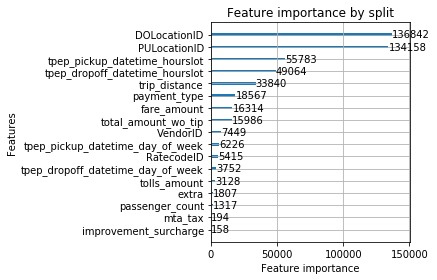

In [24]:
# Default feature importance is "split" which represents the number of times the feature is used by the model
lgb.plot_importance(lightgbm_model)
plt.title("Feature importance by split")
plt.tight_layout()
plt.savefig(Path(figures_dir, 'feature_importance_by_split'))
plt.show()

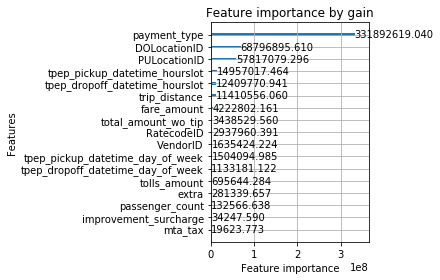

In [25]:
# Gain feature importance contains the total information gain the model has by using this feature
lgb.plot_importance(lightgbm_model, importance_type="gain")
plt.title("Feature importance by gain")
plt.tight_layout()
plt.savefig(Path(figures_dir, 'feature_importance_by_gain'))
plt.show()

Looking at whether we are plotting importance by the number of times the feature is used by the model (1st case) or the information gained by the use of a particular branch point (second case) we get pretty different results. 

Readings:
Interpretability with XGBoost
https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27

For census data and XGBoost:
https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html

It seems like pick-up and drop-off location seem to be strong predictors, but we might have to control for the distance. 


### Use SHAP explainer

In [27]:
import shap
shap.initjs() 
# samples = X_sample

In [28]:
explainer = shap.TreeExplainer(lightgbm_model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [29]:
def get_shapley_values(explainer, X, y, sample_size):
    """
    Returns the X, y samples and shaply values for that sample
    """

    random_state = 42
    X_sample = X.sample(sample_size, random_state=random_state)
    y_sample = y.sample(sample_size, random_state=random_state)
    
    print('Getting shapley values')
    shap_values = explainer.shap_values(X_sample)
    
    return X_sample, y_sample, shap_values

In [30]:
sample_size = 100000
X, y = dtp.dask_Xy_to_df(X_test, y_test, target, partitions_to_concat)
samples, y_sample, shap_values = get_shapley_values(explainer, X, y, sample_size)

Getting shapley values


In [31]:
print(type(shap_values[0]))

<class 'numpy.ndarray'>


In [32]:
def shap_summary_plot(shap_values, samples):
    """
    Save a SHaP summary plot of the samples
    """
    shap.summary_plot(shap_values,
                  samples, 
                  show=False)
    plt.tight_layout()
    plt.savefig(Path(figures_dir, 'shap_summary'))

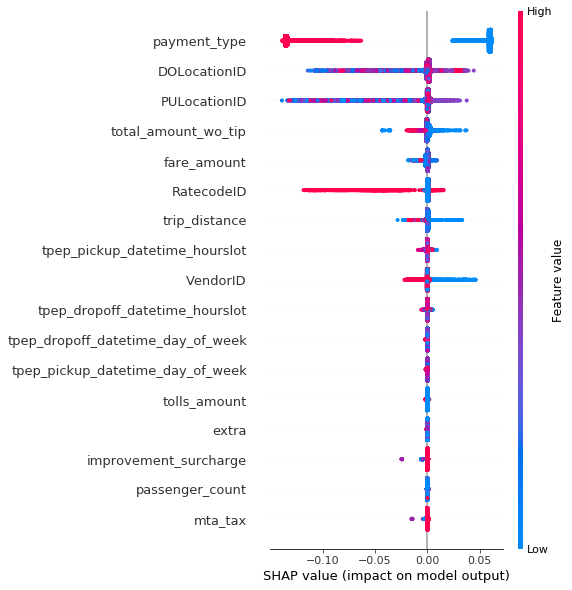

In [34]:
shap_summary_plot(shap_values, samples)

In [35]:
# shap.summary_plot(shap_values, X_importance, plot_type='bar')

In [36]:
# TODO compared summary to logistic regression weights for the same test set

## ShAP interactions

In [37]:
# import pandas as pd
# X_interaction = X_importance.iloc[:500,:]
# shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(X_interaction)

In [38]:
# shap_interaction_values = shap.TreeExplainer(lgb_model).shap_interaction_values(X_interaction)

### Extract features list 

In [39]:
# shap_sum = np.abs(shap_values).mean(axis=0)
# importance_df = pd.DataFrame([X_importance.columns.tolist(), shap_sum.tolist()]).T
# importance_df.columns = ['column_name', 'shap_importance']
# importance_df = importance_df.sort_values('shap_importance', ascending=False)
# importance_df

### Dependence Plots

To evaluate feature importance of our categorical features in more detail, we can look at scatter plots highlighting their individual contributions to the model predictions

In [40]:
# Understanding output: https://towardsdatascience.com/explain-any-models-with-the-shap-values-use-the-kernelexplainer-79de9464897a

In [41]:
# shap.dependence_plot?

In [42]:
"""
Plots the value of the feature on the x-axis and the SHAP value of the same feature
on the y-axis. This shows how the model depends on the given feature, and is like a
richer extenstion of the classical parital dependence plots. Vertical dispersion of the
data points represents interaction effects. Grey ticks along the y-axis are data
points where the feature's value was NaN.
"""
feature_names = ['Credit card', \
              'Cash',\
              'No charge', \
              'Dispute']

column_of_interest = "payment_type"

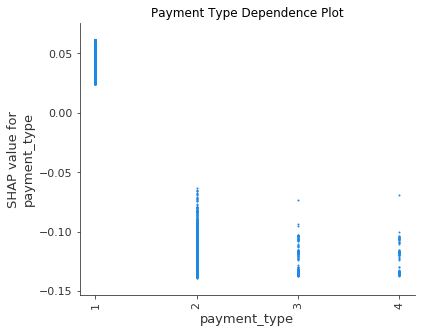

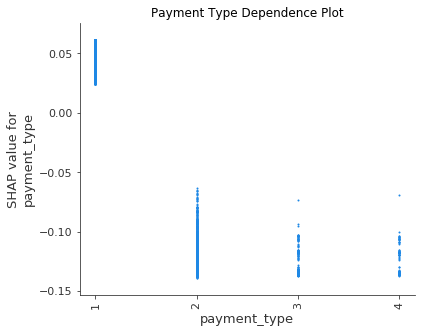

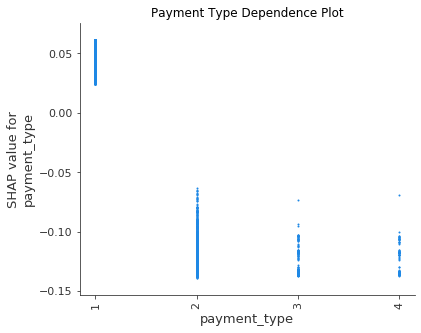

In [43]:
# make plots colored by each of the top three possible interacting features
inds = shap.approximate_interactions(column_of_interest, shap_values, samples)
for i in range(3):
    shap.dependence_plot(column_of_interest, 
                         shap_values, 
                         samples, 
                         dot_size = 4,
#                          interaction_index=inds[i], 
                         interaction_index=None,
                         show=False)
    plt.title("Payment Type Dependence Plot")


    

 Looking at fare_amount, trip_distance, total_amount_wo_tip (all highly correlated features), we can see that the model does not know what to predict one way or another when it is a short trip, the tip is up in the air. However, given a credit car payment, it seems to be more likely that there will be a tip (or at least that it will be reported)

## Unpacking a single example

In [44]:
i=3
print('Actual tip: ' + str(y_sample.iloc[i]))
shap.force_plot(explainer.expected_value, shap_values[i], features=samples.iloc[i])

Actual tip: 0.0


In [45]:
i=1
print('Actual tip: ' + str(y_sample.iloc[i]))
shap.force_plot(explainer.expected_value, shap_values[i], features=samples.iloc[i])

Actual tip: 0.19852941176470587


In [46]:
i=56
print('Actual tip: ' + str(y_sample.iloc[i]))
shap.force_plot(explainer.expected_value, shap_values[i], features=samples.iloc[i])

Actual tip: 0.15706806282722513


Perhaps it wasn't reported!

## Let's look at tip fraction by location plot

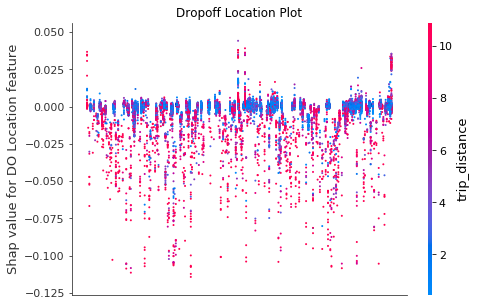

In [47]:
import matplotlib.pyplot as plt

# %matplotlib inline
shap.dependence_plot("DOLocationID", 
                     shap_values, 
                     samples, 
#                      x_jitter=1,
#                      xmin="percentile(1)",
                     interaction_index='trip_distance',
                     dot_size = 4,
                     show=False)

plt.title("Dropoff Location Plot")
plt.ylabel("Shap value for DO Location feature")
# plt.savefig("dropoff_location_dependency.pdf") # we can save a PDF of the figure if we want
frame = plt.gca()

frame.axes.set_xticks(frame.axes.get_xticks()[::6])

frame.axes.get_xaxis().set_visible(False)
plt.show()

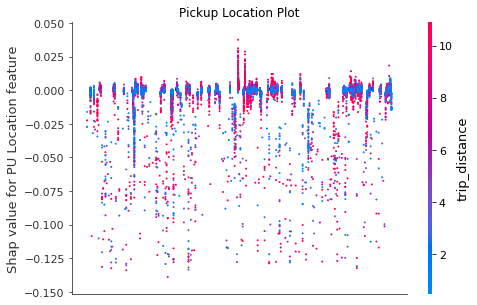

In [48]:
import matplotlib.pyplot as plt

# %matplotlib inline
shap.dependence_plot("PULocationID", 
                     shap_values, 
                     samples, 
#                      x_jitter=1,
#                      xmin="percentile(1)",
                     interaction_index='trip_distance',
                     dot_size = 4,
                     show=False)

plt.title("Pickup Location Plot")
plt.ylabel("Shap value for PU Location feature")
# plt.savefig("dropoff_location_dependency.pdf") # we can save a PDF of the figure if we want
frame = plt.gca()

frame.axes.set_xticks(frame.axes.get_xticks()[::6])

frame.axes.get_xaxis().set_visible(False)
plt.show()

There seem to be too many locations to paint a clear picture, lets drill down to an areas of interest

In [49]:
category_count = 15
cat_col_of_interest = 'DOLocationID'

In [50]:
# Getting the mean results in the sample for each DO
temp_df = samples.copy()
temp_df[target] = y_sample
mean_tip_by_col = temp_df.groupby(cat_col_of_interest)[target].mean()

In [51]:
mean_tip_by_col.sort_values(ascending=False, inplace = True)

In [52]:
cat_list = mean_tip_by_col[:category_count].index.values

In [53]:
sub_sample = samples[samples[cat_col_of_interest].isin(cat_list)]

In [54]:
ss_shap_values = explainer.shap_values(sub_sample)

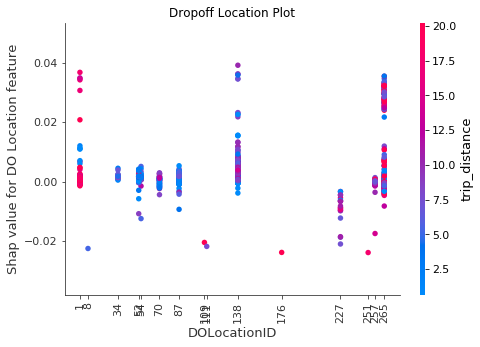

In [55]:
import matplotlib.pyplot as plt
plot_details = shap.dependence_plot(cat_col_of_interest, 
                     ss_shap_values, 
                     sub_sample, 
                     dot_size = 30,
                     interaction_index='trip_distance',
                     show=False)

# ax = plt.gca()
# print(ax.lines)
# x_data = ax.get_xdata()
# y_data = ax.get_ydata()

plt.title("Dropoff Location Plot")
plt.ylabel("Shap value for DO Location feature")
plt.show()

In [56]:
print(mean_tip_by_col[:category_count])

DOLocationID
176    0.300055
227    0.259125
1      0.251655
265    0.217931
70     0.205315
251    0.200050
8      0.200000
111    0.199938
109    0.199834
34     0.181486
54     0.169908
52     0.169391
257    0.165298
138    0.159332
87     0.158325
Name: tip_fraction, dtype: float64


In [57]:
# TODO try expanding sample
counts = sub_sample[cat_col_of_interest].value_counts()
counts[:10]

138    1074
87      682
265     232
1       195
52       79
70       48
257      34
54       29
227      19
34       11
Name: DOLocationID, dtype: int64

Seems the sample needs to be increased to get real representations of these different regions